In [8]:
import os
import glob
import datetime
import numpy as np
from astropy.io import fits
from photutils import DAOStarFinder, CircularAperture
import photutils.psf
import matplotlib.pyplot as plt
from astropy.visualization import LogStretch, AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy.signal import peak_widths
import astropy.units as u
import pandas as pd
from scipy import stats
from calibFuncs import * #sortData, starLocate, nircEPSF, calcBinDist

In [9]:
datadir = 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\William\\trapezium_data\\clio_astro\\reduced'
Clio_datasets = sortData(datadir)

In [38]:
Clio_datasets[0][12]

['C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\\William\\trapezium_data\\clio_astro\\reduced\\coadds\\traph_00001_LBP_nodsub_COADD.fit.gz',
 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\\William\\trapezium_data\\clio_astro\\reduced\\coadds\\traph_00006_LBP_nodsub_COADD.fit.gz']

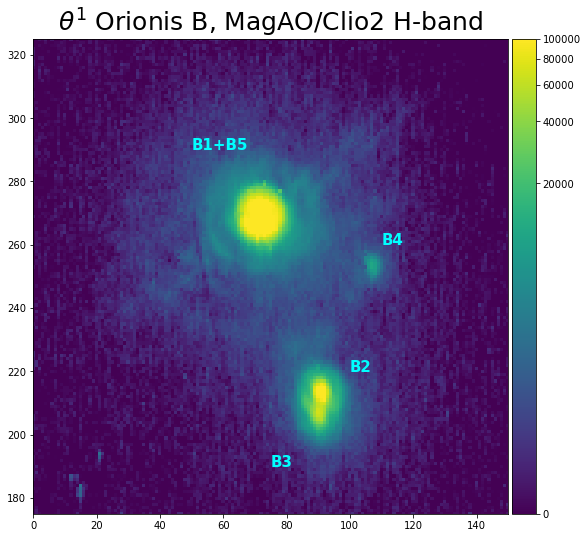

In [64]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(9,9))
ax = plt.gca()
im = ax.imshow(fits.getdata(Clio_datasets[0][12][0]), norm=ImageNormalize(stretch=AsinhStretch(a=0.01), vmin=0, vmax=100000), origin='lower')
ax.set_xlim(0,150)
ax.set_ylim(175,325)
plt.annotate(xy=[50,290], s='B1+B5', c='cyan', size=15, weight='bold')
plt.annotate(xy=[110,260], s='B4', c='cyan', size=15, weight='bold')
plt.annotate(xy=[100,220], s='B2', c='cyan', size=15, weight='bold')
plt.annotate(xy=[75,190], s='B3', c='cyan', size=15, weight='bold')
plt.title(r'$\theta^1$ Orionis B, MagAO/Clio2 H-band', size=25)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.savefig('tet1oriB_Clio.png', dpi=150, transparent=True)


In [9]:
Clio_datasets[0][4:5]

[['C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\\William\\trapezium_data\\clio_astro\\reduced\\coadds\\trap33_00001_LBP_nodsub_COADD.fit.gz',
  'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\\William\\trapezium_data\\clio_astro\\reduced\\coadds\\trap33_00006_LBP_nodsub_COADD.fit.gz']]

Choose a reference star image to create a reference PSF from


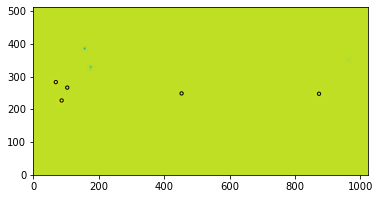

    xcentroid          ycentroid           roundness      
------------------ ------------------ --------------------
 86.12849309993409 226.85689302095108  0.08144722008157342
 873.3396188708278 247.32477671926512  0.07243664573459364
 452.9964981442261 248.37339847763636 0.034739761227591884
103.25329071256402  266.2454052425429  0.06272888197094172
 68.30962771279998 282.95865158198217   0.0674214993688123
input the 0 indexed integer of your target from the table above: 4
target star is at  68 , 282  at FWHM 7.299234424158428


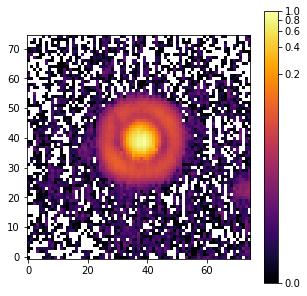

Select your target system to fit positions to


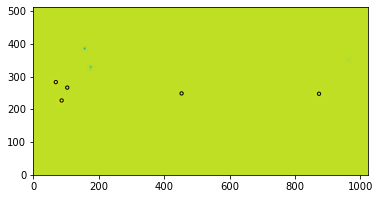

    xcentroid          ycentroid           roundness      
------------------ ------------------ --------------------
 86.12849309993409 226.85689302095108  0.08144722008157342
 873.3396188708278 247.32477671926512  0.07243664573459364
 452.9964981442261 248.37339847763636 0.034739761227591884
103.25329071256402  266.2454052425429  0.06272888197094172
 68.30962771279998 282.95865158198217   0.0674214993688123
input the 0 indexed integer of your target from the table above: 0
target star is at  86 , 226  at FWHM 7.112658344422627
Stars found at positions
       x_0               y_0        
----------------- ------------------
38.04594463038657 38.125250931933884
       x_0                y_0       
------------------ -----------------
37.376037174063754 31.15962067965483

7.731011160612105 +/- 0.07678030320094412
172.9333470063204 +/- 1.1071865593472694
Choose a reference star image to create a reference PSF from


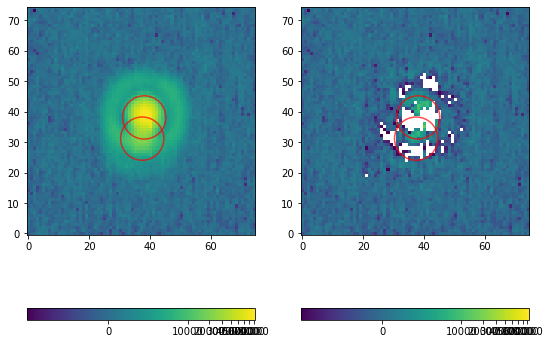

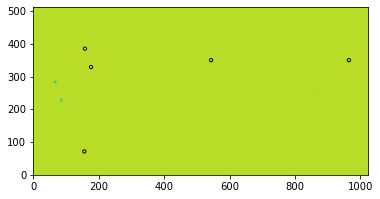

    xcentroid         ycentroid            roundness      
----------------- ------------------ ---------------------
 155.565610152945  70.99023429873088   0.07337592945444613
176.0046175937174  328.9140617883735   0.09607212218468877
543.3267873820847  350.0031469641458   0.02742804231640241
964.7049658467444 350.07029259140387 0.0014455459691194354
157.2758819363238  385.4668975483368    0.0826202381723147
input the 0 indexed integer of your target from the table above: 4
target star is at  157 , 385  at FWHM 6.948263242698857


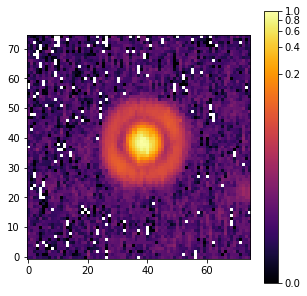

Select your target system to fit positions to


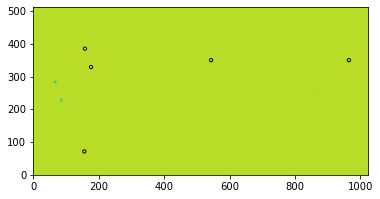

    xcentroid         ycentroid            roundness      
----------------- ------------------ ---------------------
 155.565610152945  70.99023429873088   0.07337592945444613
176.0046175937174  328.9140617883735   0.09607212218468877
543.3267873820847  350.0031469641458   0.02742804231640241
964.7049658467444 350.07029259140387 0.0014455459691194354
157.2758819363238  385.4668975483368    0.0826202381723147
input the 0 indexed integer of your target from the table above: 1
target star is at  176 , 328  at FWHM 6.724833182376528
Stars found at positions
       x_0              y_0       
----------------- ----------------
37.92015945269598 38.3771908110198
       x_0                y_0       
------------------ -----------------
36.933168449743675 31.34679313554695

7.689459566105384 +/- 0.07677807510270064
171.1877317226787 +/- 1.0307144539641513


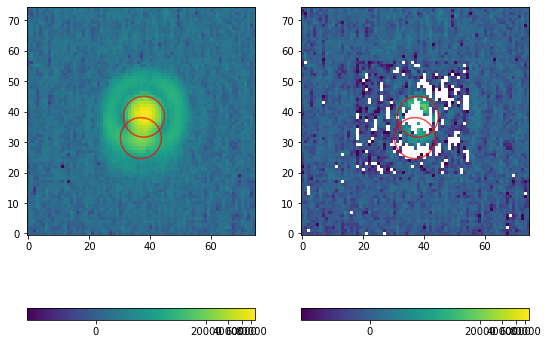

In [10]:
data_frames = []
for dataset in Clio_datasets[0][4:5]:
    data = []
    for image in dataset:
        phot_results = ClioLocate(image, 500, 5, 5, stampsize=75, epsfstamp=75, roundness=0.5, iterations=2, crit_sep=10, setfwhm=False)
        data.append(phot_results)
    data2 = np.asarray(data)
    data_frames.append(pd.DataFrame(data=data2, columns=['sep','seperr','PA','PAerr']))

In [11]:
data_frames

[        sep    seperr          PA     PAerr
 0  7.731011  0.076780  172.933347  1.107187
 1  7.689460  0.076778  171.187732  1.030714]

In [12]:
data_frames[0].to_clipboard()